In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

path1 = '/Users/mouyasushi/Desktop/vici holdings/Test/data/train_data.npy'
train_data = np.load(path1)

path2 = '/Users/mouyasushi/Desktop/vici holdings/Test/data/train_labels.npy'
train_labels = np.load(path2)

# 轉換為 DataFrame
df = pd.DataFrame(train_data)
df['label'] = train_labels  # 添加標籤列


In [2]:
def check_missing_values(df):
   
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    missing_data = pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    })
    
    missing_data = missing_data[missing_data['missing_percent'] > 0].sort_values('missing_percent', ascending=False)
    
    if len(missing_data) > 0:
        print("missing values:")
        print(missing_data)
    else:
        print("no missing values")
    
    return missing_data

def detect_constant_features(df):
    constant_features = []
    
    for col in df.columns:
        if df[col].nunique() == 1:
            constant_features.append(col)

    
    return constant_features

def detect_binary_features(df):
    binary_features = []
    
    for col in df.columns:
    
        if df[col].dtype != 'object':
            unique_values = df[col].unique()
            if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
                binary_features.append(col)
    
    return binary_features


In [3]:
missing_data = check_missing_values(df)
missing_data

no missing values


,missing_count,missing_percent


In [4]:
constant_feature = detect_constant_features(df)
constant_feature

[]

Analyze Binary feature 

In [5]:
binary_feature = detect_binary_features(df)
binary_feature

[56, 57, 58, 59, 60]

analyze feature skewness
- threshold  = 1.0 

In [6]:
def analyze_skewness(df, threshold=1.0):
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    skew_values = df[numeric_cols].skew()
    
    highly_skewed = skew_values[abs(skew_values) > threshold].sort_values(ascending=False)
    
    return highly_skewed



In [7]:
skewed_features = analyze_skewness(df)
skewed_features.head()

52    465.216052
67     85.777991
65     60.587154
61     60.378028
62     60.289686
dtype: float64

analyze feature kurtosis 
- threshold  = 3 

In [8]:
def analyze_kurtosis(df, threshold=3.0):
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    kurt_values = df[numeric_cols].kurtosis()
    
    high_kurtosis = kurt_values[kurt_values > threshold].sort_values(ascending=False)
    
    if len(high_kurtosis) > 0:
        print(f"high kurtosis feature (kurtosis > {threshold}):")
        print(high_kurtosis)
    else:
        print(f"no high kurtosis feature (kurtosis > {threshold})")
    
    return high_kurtosis


In [9]:
kurt_features = analyze_kurtosis(df)
kurt_features.head()

high kurtosis feature (kurtosis > 3.0):
52    341159.105444
67      8739.241466
65      4363.527474
62      4303.511064
61      4300.096712
64      4237.464057
63      3839.787366
66       451.778121
55       349.670870
49       229.815216
69        53.654486
4         43.335396
2         42.065093
5         41.680203
3         35.947979
17        22.461061
15        21.065172
68        20.851945
53        12.811908
54         9.201924
40         8.777380
14         8.200595
16         7.954253
57         4.593446
56         4.245312
42         3.792548
44         3.289681
13         3.158244
dtype: float64


52    341159.105444
67      8739.241466
65      4363.527474
62      4303.511064
61      4300.096712
dtype: float64

analyze feature with outliers 
- threshold : z > 3 
- in order to see features with fat tail distribution 

In [10]:
def detect_outliers_zscore(df, threshold=3.0):
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    outlier_counts = {}
    
    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outliers = (z_scores > threshold).sum()
        if outliers > 0:
            outlier_counts[col] = outliers
    
    # 排序并显示结果
    if outlier_counts:
        outlier_df = pd.DataFrame({
            'outlier_count': outlier_counts,
            'percentage(%)': {k: (v/len(df))*100 for k, v in outlier_counts.items()}
        }).sort_values('outlier_count', ascending=False)
        print("(|Z| > {}):".format(threshold))
        print(outlier_df)
    else:
        print(f"no outliers detected (|Z| > {threshold})")
    
    

In [11]:
outliers_zscore = detect_outliers_zscore(df)
outliers_zscore

(|Z| > 3.0):
    outlier_count  percentage(%)
16          53580       4.562093
15          52145       4.439909
17          48889       4.162675
14          42395       3.609741
53          41529       3.536005
..            ...            ...
61           1242       0.105751
64           1242       0.105751
62           1242       0.105751
0             788       0.067095
24            128       0.010899

[65 rows x 2 columns]


In [45]:

    
def plot_feature_distribution(df, feature, figsize=(12, 5)):
    
    plt.figure(figsize=figsize)
    
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} distribution')
    plt.xlabel(feature)
    plt.ylabel('frequency')
    
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[feature])
    plt.title(f'{feature} boxplot')
    plt.tight_layout()
    plt.show()
    
    
    print(f"\n{feature} statistics:")
    desc = df[feature].describe()
    print(desc)
    print(f"skewness: {df[feature].skew():.4f}")
    print(f"kurtosis: {df[feature].kurtosis():.4f}")



Plot each feature's :
- distributions 
- box plot 

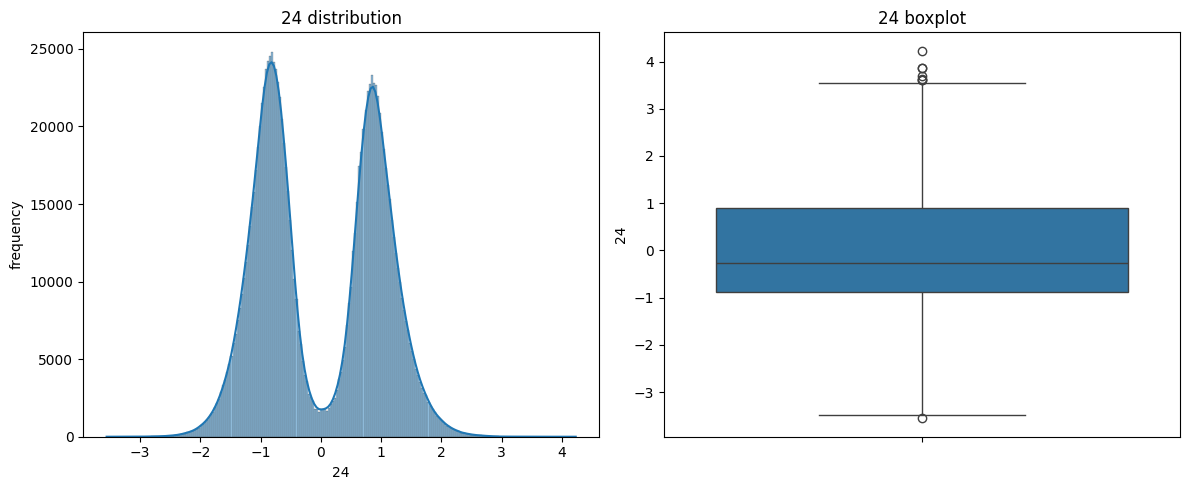


24 statistics:
count    1.174461e+06
mean     3.926416e-18
std      9.999996e-01
min     -3.557451e+00
25%     -8.784684e-01
50%     -2.575400e-01
75%      9.004684e-01
max      4.229294e+00
Name: 24, dtype: float64
skewness: 0.0757
kurtosis: -1.3141


In [46]:
plot_feature_distribution(df, 24)

For those features that was highly skewed: 
- we should do transformation before standardization 
    - since standardization didn't change the distribution that much 

- method : log, sqrt, boxcox, yeo-johson. All suitable for different data type 

In [15]:
def feature_transformation(df, features_to_transform, method='log'):
    
    df_transformed = df.copy()
    
    for feature in features_to_transform:  # only transform the features in the list
        
        if feature not in df.columns:
            print(f" {feature} not exist, skip")
            continue
        
        
        if not np.issubdtype(df[feature].dtype, np.number):
            print(f" {feature} is not numeric, skip")
            continue
            
        
        current_method = method
        
        
        if current_method == 'log':
            if (df[feature] <= 0).any():
                print(f" {feature} has 0 or negative value, not suitable for log transformation")
                if (df[feature] < 0).any():
                    print(f" {feature} has negative values, using yeo-johnson instead")
                    current_method = 'yeo-johnson'
                else:  
                    print(f" {feature} has zero values, using boxcox with offset instead")
                    current_method = 'boxcox'
        
        
        try:
            if current_method == 'log':
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"applied log transformation to {feature}")
                
            elif current_method == 'sqrt':
                if (df[feature] < 0).any():
                    print(f" {feature} has negative values, not suitable for sqrt transformation")
                    print(f" using yeo-johnson instead")
                    current_method = 'yeo-johnson'
                    df_transformed[f"{feature}_yeojohnson"], _ = stats.yeojohnson(df[feature])
                    print(f"applied yeo-johnson transformation to {feature}")
                else:
                    df_transformed[f"{feature}_sqrt"] = np.sqrt(df[feature])
                    print(f"applied square root transformation to {feature}")
                
            elif current_method == 'boxcox':
                
                if (df[feature] <= 0).any():
                    min_val = df[feature].min()
                    shift = abs(min_val) + 1
                    shifted_values = df[feature] + shift
                    df_transformed[f"{feature}_boxcox"], lambda_val = stats.boxcox(shifted_values)
                    print(f"applied boxcox transformation to {feature} (with +{shift} offset)")
                else:
                    df_transformed[f"{feature}_boxcox"], lambda_val = stats.boxcox(df[feature])
                    print(f"applied boxcox transformation to {feature} (lambda={lambda_val:.4f})")
                    
            elif current_method == 'yeo-johnson':
                df_transformed[f"{feature}_yeojohnson"], lambda_val = stats.yeojohnson(df[feature])
                print(f"applied yeo-johnson transformation to {feature} (lambda={lambda_val:.4f})")
                
            else:
                print(f"Unknown transformation method '{current_method}' for {feature}, skip")
                
        except Exception as e:
            print(f"Error applying {current_method} transformation to {feature}: {str(e)}")
    
    return df_transformed

In [16]:
skewed_features.index

Index([52, 67, 65, 61, 62, 64, 63, 66, 69,  5, 49,  3, 68, 53, 57, 56, 54, 55,
       51, 15, 31, 34, 41, 43, 39, 16, 14, 44, 42, 40,  4,  2],
      dtype='object')

In [17]:

skewed_features = [52, 67, 65, 61, 62, 64, 63, 66, 69, 5, 49, 3, 68, 53, 57, 56, 54, 55, 51, 15, 31, 34, 41, 43, 39, 16, 14, 44, 42, 40, 4, 2]

binary_feature = [56, 57, 58, 59, 60] # we don't want to do transformation to binary features 

to_be_transformed = list(set(skewed_features) - set(binary_feature))

to_be_transformed

[2,
 3,
 4,
 5,
 14,
 15,
 16,
 31,
 34,
 39,
 40,
 41,
 42,
 43,
 44,
 49,
 51,
 52,
 53,
 54,
 55,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69]

In [18]:
df_transformed = feature_transformation(df, to_be_transformed, method='yeo-johnson') 
# setting yeo_johnson to default 
# since it can deal with positive and negative skewed 

applied yeo-johnson transformation to 2 (lambda=1.3159)
applied yeo-johnson transformation to 3 (lambda=0.5655)
applied yeo-johnson transformation to 4 (lambda=1.2665)
applied yeo-johnson transformation to 5 (lambda=0.5671)
applied yeo-johnson transformation to 14 (lambda=1.3565)
applied yeo-johnson transformation to 15 (lambda=1.1062)
applied yeo-johnson transformation to 16 (lambda=1.3350)
applied yeo-johnson transformation to 31 (lambda=1.6273)
applied yeo-johnson transformation to 34 (lambda=1.7628)
applied yeo-johnson transformation to 39 (lambda=2.1355)
applied yeo-johnson transformation to 40 (lambda=2.8369)
applied yeo-johnson transformation to 41 (lambda=2.0686)
applied yeo-johnson transformation to 42 (lambda=2.2423)
applied yeo-johnson transformation to 43 (lambda=2.0269)
applied yeo-johnson transformation to 44 (lambda=2.1412)
applied yeo-johnson transformation to 49 (lambda=0.7191)
applied yeo-johnson transformation to 51 (lambda=0.3627)
applied yeo-johnson transformation 

In [19]:
df_transformed.columns

Index([              0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,
       ...
       '55_yeojohnson', '61_yeojohnson', '62_yeojohnson', '63_yeojohnson',
       '64_yeojohnson', '65_yeojohnson', '66_yeojohnson', '67_yeojohnson',
       '68_yeojohnson', '69_yeojohnson'],
      dtype='object', length=101)

Standardize : 使用 standard scaler 
- for highly skewed feature : 
    - we trans , and then standardize 
- for feature with high kurtosis ; 
    - we only do standardization 

In [20]:
from sklearn.preprocessing import StandardScaler

def standardize_features(df, features_to_standardize, return_scaler=False):
    
    df_standardized = df.copy()
    
    scaler_dict = {}
    
    valid_features = []
    for feature in features_to_standardize:
        if feature not in df.columns:
            continue
            
        
        if not np.issubdtype(df[feature].dtype, np.number):
            print(f" {feature} is not numeric, skip")
            continue
            
        valid_features.append(feature)
    
    if valid_features:
        
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(df[valid_features])
        
        
        for i, feature in enumerate(valid_features):
            df_standardized[f"{feature}_std"] = scaled_values[:, i]
            print(f"applied standardization to {feature}")
        
        if return_scaler:
            scaler_dict = {feature: (scaler.mean_[i], scaler.scale_[i]) 
                          for i, feature in enumerate(valid_features)}
    
    if return_scaler:
        return df_standardized, scaler_dict
    else:
        return df_standardized

In [21]:
kurt_features.index


Index([52, 67, 65, 62, 61, 64, 63, 66, 55, 49, 69,  4,  2,  5,  3, 17, 15, 68,
       53, 54, 40, 14, 16, 57, 56, 42, 44, 13],
      dtype='object')

In [22]:
import re
yeojohnson_cols = [col for col in df_transformed.columns if re.search('_yeojohnson$', str(col))]


In [27]:
df_transformed.columns = [str(col) for col in df_transformed.columns]

In [34]:

kurt_features = [52, 67, 65, 62, 61, 64, 63, 66, 55, 49, 69,  4,  2,  5,  3, 17, 15, 68,
       53, 54, 40, 14, 16, 57, 56, 42, 44, 13]

kurt_to_be_std = list(set(kurt_features)  - set(binary_feature))
to_be_std = yeojohnson_cols + kurt_to_be_std

std = []
for i in to_be_std: 
       std.append(str(i))
       
std
       

['2_yeojohnson',
 '3_yeojohnson',
 '4_yeojohnson',
 '5_yeojohnson',
 '14_yeojohnson',
 '15_yeojohnson',
 '16_yeojohnson',
 '31_yeojohnson',
 '34_yeojohnson',
 '39_yeojohnson',
 '40_yeojohnson',
 '41_yeojohnson',
 '42_yeojohnson',
 '43_yeojohnson',
 '44_yeojohnson',
 '49_yeojohnson',
 '51_yeojohnson',
 '52_yeojohnson',
 '53_yeojohnson',
 '54_yeojohnson',
 '55_yeojohnson',
 '61_yeojohnson',
 '62_yeojohnson',
 '63_yeojohnson',
 '64_yeojohnson',
 '65_yeojohnson',
 '66_yeojohnson',
 '67_yeojohnson',
 '68_yeojohnson',
 '69_yeojohnson',
 '64',
 '65',
 '2',
 '3',
 '4',
 '5',
 '66',
 '67',
 '68',
 '69',
 '13',
 '14',
 '15',
 '16',
 '17',
 '40',
 '42',
 '44',
 '49',
 '52',
 '53',
 '54',
 '55',
 '61',
 '62',
 '63']

In [35]:
df_standardized = standardize_features(df_transformed, std)

applied standardization to 2_yeojohnson
applied standardization to 3_yeojohnson
applied standardization to 4_yeojohnson
applied standardization to 5_yeojohnson
applied standardization to 14_yeojohnson
applied standardization to 15_yeojohnson
applied standardization to 16_yeojohnson
applied standardization to 31_yeojohnson
applied standardization to 34_yeojohnson
applied standardization to 39_yeojohnson
applied standardization to 40_yeojohnson
applied standardization to 41_yeojohnson
applied standardization to 42_yeojohnson
applied standardization to 43_yeojohnson
applied standardization to 44_yeojohnson
applied standardization to 49_yeojohnson
applied standardization to 51_yeojohnson
applied standardization to 52_yeojohnson
applied standardization to 53_yeojohnson
applied standardization to 54_yeojohnson
applied standardization to 55_yeojohnson
applied standardization to 61_yeojohnson
applied standardization to 62_yeojohnson
applied standardization to 63_yeojohnson
applied standardizat

In [42]:
for i in df_standardized.columns: 
    print(i)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
label
2_yeojohnson
3_yeojohnson
4_yeojohnson
5_yeojohnson
14_yeojohnson
15_yeojohnson
16_yeojohnson
31_yeojohnson
34_yeojohnson
39_yeojohnson
40_yeojohnson
41_yeojohnson
42_yeojohnson
43_yeojohnson
44_yeojohnson
49_yeojohnson
51_yeojohnson
52_yeojohnson
53_yeojohnson
54_yeojohnson
55_yeojohnson
61_yeojohnson
62_yeojohnson
63_yeojohnson
64_yeojohnson
65_yeojohnson
66_yeojohnson
67_yeojohnson
68_yeojohnson
69_yeojohnson
2_yeojohnson_std
3_yeojohnson_std
4_yeojohnson_std
5_yeojohnson_std
14_yeojohnson_std
15_yeojohnson_std
16_yeojohnson_std
31_yeojohnson_std
34_yeojohnson_std
39_yeojohnson_std
40_yeojohnson_std
41_yeojohnson_std
42_yeojohnson_std
43_yeojohnson_std
44_yeojohnson_std
49_yeojohnson_std
51_yeojohnson_std
52_yeojohnson_std
53_yeojohnson_std
54_yeojohnson_std
55_yeojohnson_std
61_y

outlier 處理:  
- 清掉可能導致訊息損失
- 厚尾分布在金融資料常見 
- 目前先保持不動

In [22]:
# def handle_outliers(df, features, method='cap', threshold=3.0):
#     """
#     处理离群值
#     """
#     df_cleaned = df.copy()
    
#     for feature in features:
#         if feature not in df.columns:
#             print(f"特征 {feature} 不存在，跳过")
#             continue
            
#         # 跳过非数值列
#         if not np.issubdtype(df[feature].dtype, np.number):
#             print(f"特征 {feature} 不是数值类型，跳过")
#             continue
            
#         if method == 'cap':
#             # 截断方法
#             Q1 = df[feature].quantile(0.25)
#             Q3 = df[feature].quantile(0.75)
#             IQR = Q3 - Q1
            
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
            
#             # 截断离群值
#             df_cleaned[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
#             print(f"对特征 {feature} 应用了IQR截断")
            
#         elif method == 'remove':
#             # 移除离群值
#             z_scores = np.abs(stats.zscore(df[feature].dropna()))
#             outlier_mask = z_scores > threshold
#             # 创建一个布尔掩码，其中True代表要保留的行
#             keep_mask = ~outlier_mask
            
#             # 应用掩码到数据框的行
#             # 注意：这会过滤掉整行数据，可能不是您想要的
#             original_shape = df_cleaned.shape
#             df_cleaned = df_cleaned[~outlier_mask]
#             print(f"从特征 {feature} 移除了 {original_shape[0] - df_cleaned.shape[0]} 行离群值")
            
#     return df_cleaned

In [23]:
# df_cleaned = handle_outliers(df_standardized, skewed_features.index, method='cap')

feature important analysis 
- light GBM --> more suitable 
- MI score 

Starting feature importance calculation...


Starting LightGBM model training:  60%|██████    | 3/5 [00:02<00:03,  1.52s/it]                           

Calculating feature importance...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37370
[LightGBM] [Info] Number of data points in the train set: 939568, number of used features: 156
[LightGBM] [Info] Start training from score -0.611953
[LightGBM] [Info] Start training from score -1.519381
[LightGBM] [Info] Start training from score -1.431870


Feature importance calculation complete!: 100%|██████████| 5/5 [00:41<00:00,  8.28s/it]              


Total number of original features: 156
Number of selected features: 26
Selected features explain 94.93% of total importance
Generating feature importance visualization...


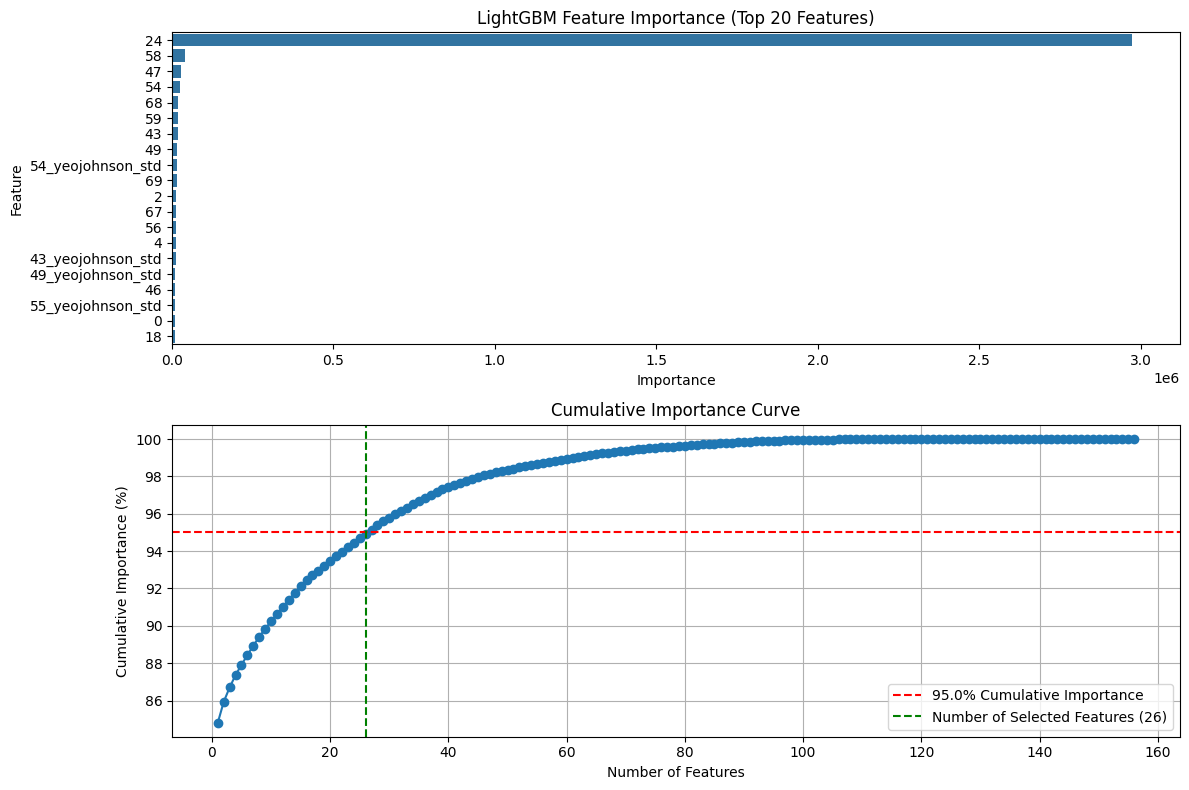

Saving results to files...
Results saved successfully!


In [36]:
from simple_feature_importance import calculate_simple_feature_importance

importance_df, selected_features = calculate_simple_feature_importance(
    df_standardized,
    target_col='label',
    categorical_features=['56', '57', '58', '59', '60'],
    threshold=0.95  
)

In [43]:
print(importance_df.head(22))
print('-'*100)
print(f'choose{len(selected_features)}features')


              feature    importance  importance_percentage  \
0                  24  2.973437e+06              84.825049   
1                  58  3.905054e+04               1.114019   
2                  47  2.691388e+04               0.767789   
3                  54  2.321156e+04               0.662170   
4                  68  1.901523e+04               0.542459   
5                  59  1.850952e+04               0.528032   
6                  43  1.747086e+04               0.498402   
7                  49  1.658123e+04               0.473023   
8   54_yeojohnson_std  1.514008e+04               0.431910   
9                  69  1.393911e+04               0.397649   
10                  2  1.380385e+04               0.393791   
11                 67  1.367235e+04               0.390039   
12                 56  1.310855e+04               0.373956   
13                  4  1.307462e+04               0.372988   
14  43_yeojohnson_std  1.247345e+04               0.355838   
15  49_y